<a href="https://colab.research.google.com/github/sultanier/ML_Cafe/blob/master/VELA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np

In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
d             = np.load('MgII.npz')
specs, labels = d['specs'], d['labels']

('random spec',
 4252,
 'total number',
 4676,
 'pixels',
 588,
 'line properties',
 array([13.7  ,  3.8  , -6.92 , -1.09 , -0.313]))

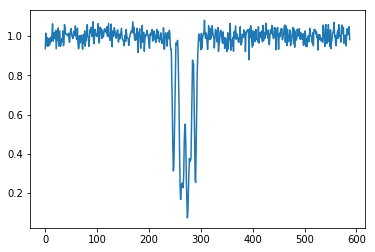

In [4]:
num_specs     = specs.shape[0]
spec_pixels   = specs.shape[1]
rad           = np.random.randint(num_specs)
example_spec  = specs[rad]
example_label = labels[rad]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
ax.plot(range(len(example_spec)), example_spec)

"random spec", rad, "total number", num_specs, "pixels", spec_pixels , "line properties", example_label

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(specs,labels, test_size=0.1, random_state=42)

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4208, 588), (468, 588), (4208, 5), (468, 5))

In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)
import random
num_input      = 588
num_classes    = 5

X             = tf.placeholder(tf.float32, [None, num_input])
Y_true        = tf.placeholder(tf.float32, [None, num_classes])

def conv_net(X, num_classes,reuse,  is_training):   
  with tf.variable_scope('ConvNet', reuse=reuse):
    x              = tf.reshape(X, shape=[-1, num_input, 1])
    h_conv1        = tf.layers.conv1d(inputs=x,filters=100,kernel_size=20,padding='same', kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), use_bias=False)
    BN_1           = tf.nn.relu(tf.layers.batch_normalization(inputs=h_conv1, training=is_training , beta_initializer=tf.contrib.layers.xavier_initializer()))
    h_pool1        = tf.layers.max_pooling1d(inputs=BN_1, pool_size=2, strides=2)
    h_conv2        = tf.layers.conv1d(inputs=h_pool1,filters=100,kernel_size=20,padding='same',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), use_bias=False)
    BN_2           = tf.nn.relu(tf.layers.batch_normalization(inputs=h_conv2, training=is_training , beta_initializer=tf.contrib.layers.xavier_initializer()))
    h_flat         = tf.reshape(BN_2, [-1, 294*100])
    h_fc1          = tf.layers.dense(inputs=h_flat, units=512,  use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
    BN_3           = tf.nn.relu(tf.layers.batch_normalization(inputs=h_fc1, training=is_training , beta_initializer=tf.contrib.layers.xavier_initializer()))
    h_fc2          = tf.layers.dense(inputs=BN_3, units=256,  use_bias=False,  kernel_initializer=tf.contrib.layers.xavier_initializer())
    BN_4           = tf.nn.relu(tf.layers.batch_normalization(inputs=h_fc2, training=is_training , beta_initializer=tf.contrib.layers.xavier_initializer()))
    h_fc3          = tf.layers.dense(inputs=BN_4, units=128,  use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
    BN_5           = tf.nn.relu(tf.layers.batch_normalization(inputs=h_fc3, training=is_training , beta_initializer=tf.contrib.layers.xavier_initializer()))
    out            = tf.layers.dense(inputs=BN_5, units=num_classes, use_bias=False,  kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.contrib.layers.xavier_initializer())
  return out


Y_pred           =  conv_net(X, num_classes,reuse=False, is_training=True) 
learning_rate    = 1e-4
train_loss             = tf.reduce_mean(tf.square(Y_true - Y_pred))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
  train_step     = tf.train.AdamOptimizer(learning_rate).minimize(train_loss)

  
test_pred       = conv_net(X, num_classes,reuse=True, is_training=False)
test_loss       = tf.reduce_mean(tf.square(Y_true - test_pred))
  

training_steps   = 2000 
batch_size       = 32

                
        

Step  0 loss train 38.4526 loss test 39.728092
Step  100 loss train 29.958567 loss test 39.857674
Step  200 loss train 23.780502 loss test 30.178753
Step  300 loss train 19.705313 loss test 24.647753
Step  400 loss train 15.238704 loss test 19.785095
Step  500 loss train 12.714795 loss test 14.7071085
Step  600 loss train 10.686992 loss test 11.554965
Step  700 loss train 7.852376 loss test 8.719707
Step  800 loss train 5.3434076 loss test 6.5117655
Step  900 loss train 4.133887 loss test 4.6757526
Step  1000 loss train 2.8085704 loss test 3.6570559
Step  1100 loss train 2.235168 loss test 2.4591012
Step  1200 loss train 1.3910652 loss test 1.8136468
Step  1300 loss train 1.010218 loss test 1.3968117
Step  1400 loss train 1.0544875 loss test 1.3249184
Step  1500 loss train 0.5674818 loss test 0.7851038
Step  1600 loss train 0.7629871 loss test 0.76346016
Step  1700 loss train 0.33381644 loss test 0.70072097
Step  1800 loss train 0.26980814 loss test 0.5861421
Step  1900 loss train 0.18

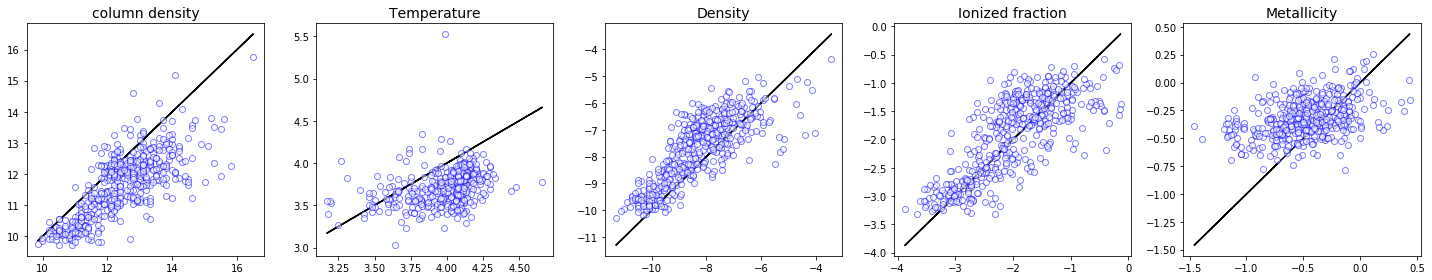

In [10]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(training_steps):
  
            rad        = random.sample(range(0,x_train.shape[0]), batch_size)
            batch_x    = x_train[rad]
            batch_y    = y_train[rad]
            sess.run(train_step, feed_dict={X:batch_x, Y_true: batch_y})
            if step % 100 == 0:
              loss_tr = sess.run(train_loss, feed_dict={X: batch_x,Y_true: batch_y})
              loss_te = sess.run(test_loss, feed_dict={X: x_test,Y_true: y_test})
              print("Step ", step, "loss train", loss_tr, "loss test", loss_te)
            

            
            
print("=======\n\n\n\n")
final_pred = sess.run(test_pred, feed_dict={X: x_test,Y_true: y_test})

fig, ax = plt.subplots(1,5, figsize=(20,4))
nn=0
      
titles = ["column density", "Temperature", "Density", "Ionized fraction", "Metallicity"]
for ii in range(5):
    ax[ii].set_title(titles[ii], fontsize=14)
    ax[ii].plot(y_test[:,nn], y_test[:,nn], 'k-')
    ax[ii].plot(y_test[:,nn], final_pred[:,nn], 'bo', mfc='white', alpha=0.5)
    nn+=1
fig.tight_layout()
        
